<a href="https://colab.research.google.com/github/jakeoung/ShapeFromProjections/blob/master/ctdr_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run the code, you need to enable the CUDA in the setting. You can enable in the menu: `Runtime > Change runtime type` and choose GPU in the hardware accelerator item.

In [1]:
# install shapefromprojections package
%cd /content
!git clone https://github.com/jakeoung/ShapeFromProjections
%cd ShapeFromProjections
!pip install -e .
import sys
import os
sys.path.append(os.getcwd())

/content
Cloning into 'ShapeFromProjections'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 206 (delta 88), reused 71 (delta 5), pack-reused 0
Receiving objects: 100% (206/206), 12.69 MiB | 5.67 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/ShapeFromProjections
Obtaining file:///content/ShapeFromProjections
     |████████████████████████████████| 634kB 3.9MB/s 
  Running setup.py develop for ctdrm


In [ ]:
# install CUDA kernels
%cd ctdr/cuda
!python build.py build_ext --inplace
%cd ../../run

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import h5py
import time

import ctdr
from parse_args import args, update_args
from ctdr.model.vanilla import Model
from ctdr.dataset import init_mesh
from ctdr.utils import util_mesh
from ctdr import optimize
import subprocess

#torch.backends.cudnn.benchmark=True

#------------------------------------------------
# load data
#------------------------------------------------
from ctdr.dataset import dataset

args.data='2starA'
# args.niter=3000
update_args(args)

if args.data.find("tomop") > 0:
    args.nmaterials = int(args.data[-3:-1])+1

ds = dataset.SinoDataset(args.ddata, args.nmaterials, args.eta)
width_physical = ds.proj_geom['DetectorSpacingX']*ds.proj_geom['DetectorColCount']
height_physical = ds.proj_geom['DetectorSpacingY']*ds.proj_geom['DetectorRowCount']
physical_unit = min(width_physical, height_physical)

finit_obj = args.ddata+'/init.obj'

# if os.path.exists(finit_obj) == False:
if True:
    init_mesh.save_init_mesh(finit_obj, args.data, args.nmaterials, physical_unit, args.subdiv)
else:
    print(f"Use existing init file {finit_obj}")

use_center_param = False
mus = np.arange(ds.nmaterials) / (ds.nmaterials-1)

print(finit_obj)
# refine
model = Model(finit_obj, ds.proj_geom, args.nmaterials,
              mus, args.nmu0, wlap=args.wlap, wflat=args.wflat).cuda()


Namespace(b=0, cuda=-1, data='2starA', dataroot='../data/', ddata='../data/2starA/', dresult='../result/2starA/ours_-b_0_-eta_0_-lr_0.01_-niter_500_-niter0_0_-nmu0_1_-subdiv_4_-wedge_2.0_-wflat_0.01_-wlap_10.0_/', eta=0, lr=0.01, niter=500, niter0=0, nmaterials=2, nmu0=1, resroot='../result', subdiv=4, verbose=1, wedge=2.0, wflat=0.01, wlap=10.0)
../data/2starA//init.obj
@statistics of mesh: # of v: 2562, f: 5120
set mu as parameters
initialize flatten loss


In [4]:
def get_params(model, exclude_mus=False):
    return model.parameters()

def run_simple(model, ds, niter, args):
    print("@ model.mus", model.mus)
    
    params = get_params(model)
    
    opt = torch.optim.Adam(params, args.lr, betas=(0.9, 0.99))
    
    idx_angles_full = torch.LongTensor(np.arange(ds.nangles))
    p_full = ds.p.cuda()
    ds_loader = [ [ idx_angles_full, p_full ]  ]

    mask_bg = ds.p < 1e-5
    mask_bg = mask_bg.cuda()

    print(f"@ statistics of mesh: {model.vertices.shape[0]}, {model.faces.shape[0]}\n")

    #mask_bg = 1
    ledge = 0
    llap = 0.
    lflat = 0.

    for epoch in range(niter):
        # if epoch % 20 == 0 or epoch == niter-1:
        for idx_angles, p_batch in ds_loader:
            displace_prev = model.displace.data.clone()
            if args.b > 0:
                p_batch = p_batch.cuda()

            opt.zero_grad()
            
            phat, mask_valid, edge_loss, lap_loss, flat_loss = model(idx_angles, args.wedge) # full angles
            # phat[~mask_valid] = 0.0
            # mask_valid = mask_valid + mask_bg
            
            # l2 loss
            data_loss = (p_batch - phat)[mask_valid].pow(2).mean()

            loss = data_loss + args.wedge * edge_loss + args.wlap * lap_loss + args.wflat * flat_loss
            
                        
            loss.backward()
            opt.step()
            
            loss_now = loss.item()
            model.mus.data.clamp_(min=0.0)

        if epoch % 20 == 0 or epoch == niter-1:            
            if args.wedge > 0.:
                ledge = edge_loss.item()
                
            if args.wlap > 0.:
                llap = lap_loss.item()
            
            if args.wflat > 0.:
                lflat = flat_loss.item()

            plt.imshow(phat.detach().cpu().numpy()[1,:,:]); plt.show()
            print(f'~ {epoch:03d} l2_loss: {data_loss.item():.8f} edge: {ledge:.6f} lap: {llap:.6f} flat: {lflat:.6f} mus: {str(model.mus.cpu().detach().numpy())}')

    return phat         

@ model.mus Parameter containing:
tensor([0., 1.], device='cuda:0', requires_grad=True)
@ statistics of mesh: 2562, 5120



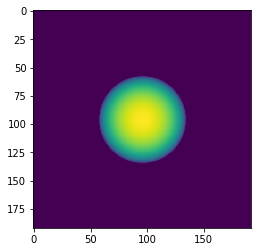

~ 000 l2_loss: 0.09115827 edge: 0.000458 lap: 0.000003 flat: 0.000000 mus: [0.01 1.01]


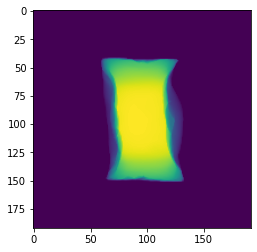

~ 020 l2_loss: 0.02561049 edge: 0.001324 lap: 0.000065 flat: 0.000000 mus: [0.        1.0899943]
ndead nneg phat.min and max_v: 1 1 -0.01, 1.52
ndead nneg phat.min and max_v: 1 1 -0.00, 1.53
ndead nneg phat.min and max_v: 2 2 -0.02, 1.53
ndead nneg phat.min and max_v: 4 4 -0.03, 1.54
ndead nneg phat.min and max_v: 13 13 -0.06, 1.54
ndead nneg phat.min and max_v: 50 50 -0.05, 1.55
ndead nneg phat.min and max_v: 86 86 -0.10, 1.55
ndead nneg phat.min and max_v: 183 183 -0.12, 1.56
ndead nneg phat.min and max_v: 216 216 -0.12, 1.56
ndead nneg phat.min and max_v: 296 296 -0.12, 1.56
ndead nneg phat.min and max_v: 373 373 -0.09, 1.56
ndead nneg phat.min and max_v: 601 601 -0.08, 1.57
ndead nneg phat.min and max_v: 697 697 -0.07, 1.58
ndead nneg phat.min and max_v: 809 809 -0.10, 1.58
ndead nneg phat.min and max_v: 854 854 -0.10, 1.58


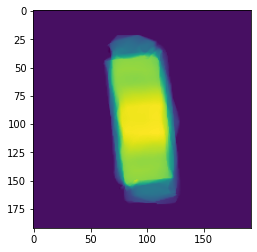

~ 040 l2_loss: 0.00300278 edge: 0.001739 lap: 0.000151 flat: 0.000000 mus: [0.        1.0273713]
ndead nneg phat.min and max_v: 830 830 -0.11, 1.59
ndead nneg phat.min and max_v: 746 746 -0.07, 1.59
ndead nneg phat.min and max_v: 657 657 -0.07, 1.59
ndead nneg phat.min and max_v: 562 562 -0.06, 1.59
ndead nneg phat.min and max_v: 466 466 -0.05, 1.59
ndead nneg phat.min and max_v: 375 375 -0.03, 1.59
ndead nneg phat.min and max_v: 260 260 -0.03, 1.59
ndead nneg phat.min and max_v: 189 189 -0.02, 1.59
ndead nneg phat.min and max_v: 165 165 -0.02, 1.59
ndead nneg phat.min and max_v: 106 106 -0.02, 1.59
ndead nneg phat.min and max_v: 69 69 -0.01, 1.59
ndead nneg phat.min and max_v: 40 40 -0.01, 1.59
ndead nneg phat.min and max_v: 3 3 -0.00, 1.60
ndead nneg phat.min and max_v: 13 13 -0.00, 1.60
ndead nneg phat.min and max_v: 11 11 -0.00, 1.60
ndead nneg phat.min and max_v: 21 21 -0.00, 1.61
ndead nneg phat.min and max_v: 45 45 -0.01, 1.61
ndead nneg phat.min and max_v: 54 54 -0.03, 1.62
nde

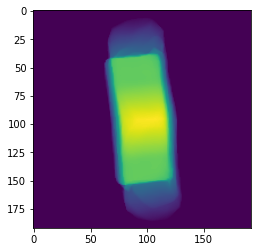

~ 060 l2_loss: 0.00031572 edge: 0.001697 lap: 0.000092 flat: 0.000000 mus: [9.459857e-04 9.988035e-01]
ndead nneg phat.min and max_v: 56 56 -4.00, 1.63
ndead nneg phat.min and max_v: 48 48 -4.00, 1.63
ndead nneg phat.min and max_v: 34 34 -4.00, 1.63
ndead nneg phat.min and max_v: 29 29 -4.02, 1.63
ndead nneg phat.min and max_v: 18 18 -4.01, 1.63
ndead nneg phat.min and max_v: 12 12 -4.02, 1.63
ndead nneg phat.min and max_v: 8 8 -4.03, 1.63
ndead nneg phat.min and max_v: 1 1 -3.98, 1.63
ndead nneg phat.min and max_v: 2 2 -0.00, 1.63
ndead nneg phat.min and max_v: 1 1 -0.00, 1.63
ndead nneg phat.min and max_v: 1 1 -0.01, 1.63
ndead nneg phat.min and max_v: 2 2 -0.01, 1.63
ndead nneg phat.min and max_v: 3 3 -0.02, 1.63
ndead nneg phat.min and max_v: 4 4 -0.02, 1.63


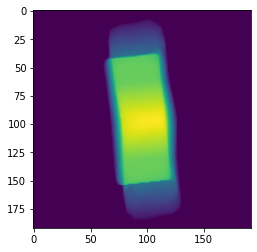

~ 080 l2_loss: 0.00014926 edge: 0.001597 lap: 0.000055 flat: 0.000000 mus: [0.        1.0106411]
ndead nneg phat.min and max_v: 1 1 -0.00, 1.62
ndead nneg phat.min and max_v: 4 4 -0.00, 1.62
ndead nneg phat.min and max_v: 3 3 -0.00, 1.61
ndead nneg phat.min and max_v: 4 4 -0.01, 1.61
ndead nneg phat.min and max_v: 7 7 -0.01, 1.61
ndead nneg phat.min and max_v: 12 12 -0.01, 1.61
ndead nneg phat.min and max_v: 14 14 -0.01, 1.61
ndead nneg phat.min and max_v: 19 19 -0.01, 1.61
ndead nneg phat.min and max_v: 16 16 -0.01, 1.61
ndead nneg phat.min and max_v: 18 18 -0.01, 1.61
ndead nneg phat.min and max_v: 23 23 -0.01, 1.61
ndead nneg phat.min and max_v: 24 24 -0.03, 1.61
ndead nneg phat.min and max_v: 34 34 -0.02, 1.61
ndead nneg phat.min and max_v: 37 37 -0.03, 1.61
ndead nneg phat.min and max_v: 44 44 -0.03, 1.61
ndead nneg phat.min and max_v: 43 43 -0.02, 1.61
ndead nneg phat.min and max_v: 40 40 -0.02, 1.61


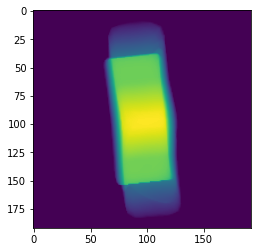

~ 100 l2_loss: 0.00011810 edge: 0.001538 lap: 0.000040 flat: 0.000000 mus: [0.        1.0070667]
ndead nneg phat.min and max_v: 35 35 -0.01, 1.61
ndead nneg phat.min and max_v: 31 31 -0.01, 1.61
ndead nneg phat.min and max_v: 25 25 -0.01, 1.61
ndead nneg phat.min and max_v: 18 18 -0.01, 1.61
ndead nneg phat.min and max_v: 21 21 -0.01, 1.61
ndead nneg phat.min and max_v: 19 19 -0.02, 1.61
ndead nneg phat.min and max_v: 22 22 -0.01, 1.61
ndead nneg phat.min and max_v: 18 18 -0.01, 1.61
ndead nneg phat.min and max_v: 14 14 -0.01, 1.61
ndead nneg phat.min and max_v: 12 12 -0.01, 1.61
ndead nneg phat.min and max_v: 2 2 -0.00, 1.61


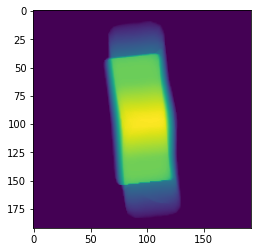

~ 120 l2_loss: 0.00010206 edge: 0.001508 lap: 0.000034 flat: 0.000000 mus: [7.5905969e-06 1.0082035e+00]
ndead nneg phat.min and max_v: 1 1 -3.67, 1.61


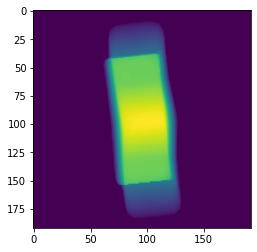

~ 140 l2_loss: 0.00009046 edge: 0.001494 lap: 0.000030 flat: 0.000000 mus: [1.6658308e-06 1.0077050e+00]


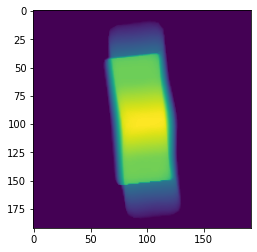

~ 160 l2_loss: 0.00008108 edge: 0.001486 lap: 0.000027 flat: 0.000000 mus: [0.        1.0078198]
ndead nneg phat.min and max_v: 1 1 -3.93, 1.61


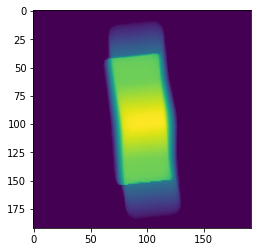

~ 180 l2_loss: 0.00007412 edge: 0.001483 lap: 0.000026 flat: 0.000000 mus: [0.        1.0077693]


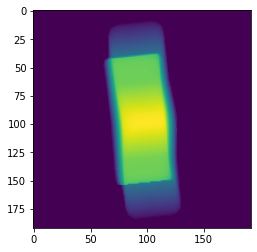

~ 199 l2_loss: 0.00007212 edge: 0.001479 lap: 0.000024 flat: 0.000000 mus: [0.        1.0073601]


In [5]:
args.wlap = 10.0
args.wflat = 0.0
args.wedge = 1.0
phat = run_simple(model, ds, 200, args)

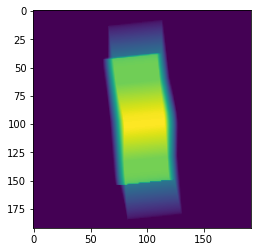

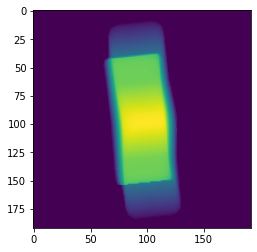

In [6]:
# Show the projection image of data and our estimation
plt.imshow(ds.p[1,:,:]); plt.show()
plt.imshow(phat.detach().cpu().numpy()[1,:,:]); plt.show()

In [7]:
# Optional: save the results
# vv = model.vertices.cpu()+model.displace.detach().cpu()
# ff = model.faces.cpu()

# labels_v, labels_f = model.labels_v_np, model.labels.cpu().numpy()
# # util_vis.save_vf_as_img_labels(args.dresult+f'{epoch:04d}_render.png', vv, ff, labels_v, labels_f)
# util_vis.save_sino_as_img(args.dresult+f'{epoch:04d}_sino.png', phat.detach().cpu().numpy())
# util_mesh.save_mesh(args.dresult+f'{epoch:04d}.obj', vv.numpy(), ff.numpy(), labels_v, labels_f)

# util_mesh.save_mesh(args.dresult+'mesh.obj', vv.numpy(), ff.numpy(), labels_v, labels_f)
# util_vis.save_sino_as_img(args.dresult+f'{epoch:04d}_data.png', ds.p.cuda())